In [1]:
!pip install kaggle
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets list -s fruit

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten --unzip -p /content/data

Dataset URL: https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten
License(s): CC0-1.0
100% 4.75G/4.77G [03:40<00:01, 14.8MB/s]
100% 4.77G/4.77G [03:40<00:00, 23.2MB/s]


In [7]:
import os
print("Contents of /content/data:")
for root, dirs, files in os.walk('/content/data'):
    level = root.replace('/content/data', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files
        print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... and {len(files)-5} more files')

Contents of /content/data:
data/
  Fruit And Vegetable Diseases Dataset/
    Tomato__Healthy/
      freshTomato (309).png
      freshTomato (79).png
      freshTomato (45).png
      freshTomato (11).jpg
      freshTomato (31).png
      ... and 599 more files
    Carrot__Rotten/
      rottenCarrot (236).jpg
      rottenCarrot (249).jpg
      rottenCarrot (488).jpg
      rottenCarrot (552).jpg
      rottenCarrot (248).jpg
      ... and 575 more files
    Bellpepper__Healthy/
      freshPepper (245).jpg
      freshPepper (115).jpg
      freshPepper (139).jpg
      freshPepper (19).jpg
      freshPepper (557).jpg
      ... and 606 more files
    Potato__Healthy/
      freshPotato (137).jpg
      freshPotato (490).jpg
      freshPotato (325).jpg
      freshPotato (54).jpg
      freshPotato (505).jpg
      ... and 610 more files
    Bellpepper__Rotten/
      rottenPepper (378).jpg
      rottenPepper (529).jpg
      rottenPepper (338).jpg
      rottenPepper (545).jpg
      rottenPepper (135).

In [8]:
# Verify download
print(" Dataset downloaded!")
!ls /content/data | head -10

 Dataset downloaded!
Fruit And Vegetable Diseases Dataset


In [9]:
# Check GPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


 Using device: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB


In [10]:

# CELL 2: Import Libraries


import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time
from collections import defaultdict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [11]:

# CELL 3: Configuration


class Config:

    DATA_DIR = "/content/data"


    BATCH_SIZE = 16
    NUM_EPOCHS = 15
    LEARNING_RATE = 0.001
    IMG_SIZE = 224


    TRAIN_RATIO = 0.7
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15


    DROPOUT_RATE = 0.3

config = Config()
print(f" Configuration set: {config.NUM_EPOCHS} epochs, batch size {config.BATCH_SIZE}")

 Configuration set: 15 epochs, batch size 16


In [12]:

# CELL 4: Dataset Class


class FreshGuardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.samples = []
        self.classes = []
        self.class_to_idx = {}

        self._load_samples()

    def _load_samples(self):
        """Load all image paths and create class mappings"""
        print(f"📁 Loading dataset from: {self.data_dir}")


        class_dirs = []
        for item in os.listdir(self.data_dir):
            item_path = os.path.join(self.data_dir, item)
            if os.path.isdir(item_path):
                class_dirs.append(item)

        class_dirs = sorted(class_dirs)


        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_dirs)}
        self.classes = class_dirs

        print(f"Found {len(self.classes)} classes:")


        total_images = 0
        for class_name in class_dirs:
            class_dir = os.path.join(self.data_dir, class_name)
            class_idx = self.class_to_idx[class_name]


            image_files = []
            for file in os.listdir(class_dir):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_files.append(file)


            for img_file in image_files:
                img_path = os.path.join(class_dir, img_file)
                self.samples.append((img_path, class_idx))

            print(f"   {class_name}: {len(image_files)} images")
            total_images += len(image_files)

        print(f" Total samples: {total_images:,}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f" Error loading {img_path}: {e}")
            blank_image = Image.new('RGB', (224, 224), color='white')
            if self.transform:
                blank_image = self.transform(blank_image)
            return blank_image, label

In [13]:

# CELL 5: Data Transforms and Splits


def get_transforms():
    """Get training and validation transforms"""
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

def create_data_splits(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Split dataset into train, validation, and test sets"""
    print("\n Creating data splits...")

    indices = list(range(len(dataset)))
    labels = [dataset.samples[i][1] for i in indices]


    train_val_indices, test_indices = train_test_split(
        indices, test_size=test_ratio, random_state=42, stratify=labels
    )


    train_val_labels = [labels[i] for i in train_val_indices]
    val_size = val_ratio / (train_ratio + val_ratio)

    train_indices, val_indices = train_test_split(
        train_val_indices, test_size=val_size, random_state=42, stratify=train_val_labels
    )

    print(f"  Dataset Split Summary:")
    print(f"  Total samples: {len(indices):,}")
    print(f"  Train: {len(train_indices):,} ({len(train_indices)/len(indices):.1%})")
    print(f"  Validation: {len(val_indices):,} ({len(val_indices)/len(indices):.1%})")
    print(f"  Test: {len(test_indices):,} ({len(test_indices)/len(indices):.1%})")

    return train_indices, val_indices, test_indices

In [14]:

# CELL 6: Model Definition


class FreshGuardEfficientNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super(FreshGuardEfficientNet, self).__init__()


        self.backbone = models.efficientnet_b0(weights='DEFAULT')


        num_features = self.backbone.classifier[1].in_features


        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.7),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)


In [15]:

# CELL 7: Training Function


def train_model(model, train_loader, val_loader, device, num_epochs=12):
    """Training function optimized for Colab"""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    history = defaultdict(list)
    best_val_acc = 0.0

    print(f"\n Starting training for {num_epochs} epochs on {device}...")
    print("=" * 70)

    for epoch in range(num_epochs):
        start_time = time.time()


        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch_idx, (data, target) in enumerate(train_bar):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()


            train_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*train_correct/train_total:.2f}%'
            })


        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for data, target in val_bar:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

                val_bar.set_postfix({'Acc': f'{100.*val_correct/val_total:.2f}%'})


        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total


        scheduler.step(val_loss)


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), '/content/best_freshguard_model.pth')
            print(f"New best model saved! Val Acc: {val_acc:.4f}")


        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print epoch results
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1:2d}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
              f"Time: {epoch_time:.1f}s")

    print("=" * 70)
    print(f" Training completed! Best validation accuracy: {best_val_acc:.4f}")

    return history, best_val_acc

In [16]:

# CELL 8: Load Data and Create Model



print(" Checking data structure...")
data_root = "/content/data"


dataset_folders = []
for item in os.listdir(data_root):
    item_path = os.path.join(data_root, item)
    if os.path.isdir(item_path):

        subfolders = [f for f in os.listdir(item_path) if os.path.isdir(os.path.join(item_path, f))]
        if len(subfolders) > 1:
            dataset_folders.append(item_path)
            print(f"Found dataset folder: {item_path}")


if dataset_folders:
    config.DATA_DIR = dataset_folders[0]
    print(f" Using dataset path: {config.DATA_DIR}")
else:

    print(f"Using original path: {config.DATA_DIR}")


print("\n Loading dataset...")
train_transform, val_transform = get_transforms()


full_dataset = FreshGuardDataset(config.DATA_DIR, transform=None)
num_classes = len(full_dataset.classes)
class_names = full_dataset.classes

print(f"\nDataset Info:")
print(f"  Classes: {num_classes}")
print(f"  Class names: {class_names}")
print(f"  Total images: {len(full_dataset):,}")


if len(full_dataset) == 0:
    print(" No images found! Let's check the folder structure...")


    for root, dirs, files in os.walk(config.DATA_DIR):
        if dirs:
            print(f"Folder: {root}")
            print(f"  Subfolders: {dirs[:10]}")
        if files:
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            if image_files:
                print(f"  Images: {len(image_files)}")
                break

    raise ValueError("No images found in dataset!")


train_indices, val_indices, test_indices = create_data_splits(full_dataset)


train_dataset = FreshGuardDataset(config.DATA_DIR, transform=train_transform)
val_dataset = FreshGuardDataset(config.DATA_DIR, transform=val_transform)
test_dataset = FreshGuardDataset(config.DATA_DIR, transform=val_transform)


train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)
test_subset = Subset(test_dataset, test_indices)


train_loader = DataLoader(train_subset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\n Data Loaders:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


print(f"\n Creating EfficientNet-B0 model...")
model = FreshGuardEfficientNet(num_classes=num_classes, dropout_rate=config.DROPOUT_RATE).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB")

print(f"\n Dataset loaded successfully!")
print(f"Ready to train on {num_classes} classes with {len(full_dataset):,} total images!")

 Checking data structure...
Found dataset folder: /content/data/Fruit And Vegetable Diseases Dataset
 Using dataset path: /content/data/Fruit And Vegetable Diseases Dataset

 Loading dataset...
📁 Loading dataset from: /content/data/Fruit And Vegetable Diseases Dataset
Found 28 classes:
   Apple__Healthy: 2438 images
   Apple__Rotten: 2925 images
   Banana__Healthy: 1999 images
   Banana__Rotten: 2797 images
   Bellpepper__Healthy: 611 images
   Bellpepper__Rotten: 591 images
   Carrot__Healthy: 619 images
   Carrot__Rotten: 579 images
   Cucumber__Healthy: 608 images
   Cucumber__Rotten: 593 images
   Grape__Healthy: 200 images
   Grape__Rotten: 200 images
   Guava__Healthy: 200 images
   Guava__Rotten: 200 images
   Jujube__Healthy: 200 images
   Jujube__Rotten: 200 images
   Mango__Healthy: 1813 images
   Mango__Rotten: 2247 images
   Orange__Healthy: 2075 images
   Orange__Rotten: 2186 images
   Pomegranate__Healthy: 200 images
   Pomegranate__Rotten: 200 images
   Potato__Healthy: 

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 150MB/s]


  Total parameters: 4,801,944
  Trainable parameters: 4,801,944
  Model size: ~18.3 MB

 Dataset loaded successfully!
Ready to train on 28 classes with 29,277 total images!


In [17]:

# CELL 9: Train the Model

print(f"\n Starting training on {device}...")
history, best_val_acc = train_model(model, train_loader, val_loader, device, config.NUM_EPOCHS)


 Starting training on cuda...

 Starting training for 15 epochs on cuda...


Epoch 1/15 [Val]: 100%|██████████| 275/275 [00:55<00:00,  4.92it/s, Acc=87.45%]


New best model saved! Val Acc: 0.8745
Epoch  1/15 | Train Loss: 0.9363 | Train Acc: 0.7280 | Val Loss: 0.4243 | Val Acc: 0.8745 | Time: 455.0s


Epoch 2/15 [Val]: 100%|██████████| 275/275 [00:53<00:00,  5.13it/s, Acc=92.26%]


New best model saved! Val Acc: 0.9226
Epoch  2/15 | Train Loss: 0.5013 | Train Acc: 0.8498 | Val Loss: 0.2721 | Val Acc: 0.9226 | Time: 446.5s


Epoch 3/15 [Val]: 100%|██████████| 275/275 [00:53<00:00,  5.10it/s, Acc=89.39%]


Epoch  3/15 | Train Loss: 0.4205 | Train Acc: 0.8739 | Val Loss: 0.3548 | Val Acc: 0.8939 | Time: 441.9s


Epoch 4/15 [Val]: 100%|██████████| 275/275 [00:53<00:00,  5.12it/s, Acc=90.76%]


Epoch  4/15 | Train Loss: 0.3601 | Train Acc: 0.8945 | Val Loss: 0.3109 | Val Acc: 0.9076 | Time: 443.4s


Epoch 5/15 [Val]: 100%|██████████| 275/275 [00:51<00:00,  5.35it/s, Acc=91.35%]


Epoch  5/15 | Train Loss: 0.3447 | Train Acc: 0.8988 | Val Loss: 0.2978 | Val Acc: 0.9135 | Time: 429.2s


Epoch 6/15 [Val]: 100%|██████████| 275/275 [00:52<00:00,  5.29it/s, Acc=93.60%]


New best model saved! Val Acc: 0.9360
Epoch  6/15 | Train Loss: 0.3022 | Train Acc: 0.9109 | Val Loss: 0.2199 | Val Acc: 0.9360 | Time: 425.4s


Epoch 7/15 [Val]: 100%|██████████| 275/275 [00:52<00:00,  5.27it/s, Acc=92.46%]


Epoch  7/15 | Train Loss: 0.2874 | Train Acc: 0.9157 | Val Loss: 0.2659 | Val Acc: 0.9246 | Time: 429.0s


Epoch 8/15 [Val]: 100%|██████████| 275/275 [00:53<00:00,  5.13it/s, Acc=94.03%]


New best model saved! Val Acc: 0.9403
Epoch  8/15 | Train Loss: 0.2871 | Train Acc: 0.9179 | Val Loss: 0.2100 | Val Acc: 0.9403 | Time: 438.2s


Epoch 9/15 [Val]: 100%|██████████| 275/275 [00:53<00:00,  5.14it/s, Acc=93.85%]


Epoch  9/15 | Train Loss: 0.2548 | Train Acc: 0.9252 | Val Loss: 0.1952 | Val Acc: 0.9385 | Time: 434.6s


Epoch 10/15 [Val]: 100%|██████████| 275/275 [00:51<00:00,  5.29it/s, Acc=94.72%]


New best model saved! Val Acc: 0.9472
Epoch 10/15 | Train Loss: 0.2462 | Train Acc: 0.9273 | Val Loss: 0.1896 | Val Acc: 0.9472 | Time: 430.7s


Epoch 11/15 [Val]: 100%|██████████| 275/275 [00:52<00:00,  5.26it/s, Acc=94.60%]


Epoch 11/15 | Train Loss: 0.2340 | Train Acc: 0.9330 | Val Loss: 0.1801 | Val Acc: 0.9460 | Time: 426.9s


Epoch 12/15 [Val]: 100%|██████████| 275/275 [00:51<00:00,  5.35it/s, Acc=95.24%]


New best model saved! Val Acc: 0.9524
Epoch 12/15 | Train Loss: 0.2359 | Train Acc: 0.9332 | Val Loss: 0.1718 | Val Acc: 0.9524 | Time: 421.8s


Epoch 13/15 [Val]: 100%|██████████| 275/275 [00:53<00:00,  5.19it/s, Acc=93.88%]


Epoch 13/15 | Train Loss: 0.2177 | Train Acc: 0.9373 | Val Loss: 0.2566 | Val Acc: 0.9388 | Time: 425.0s


Epoch 14/15 [Val]: 100%|██████████| 275/275 [00:51<00:00,  5.32it/s, Acc=94.85%]


Epoch 14/15 | Train Loss: 0.2147 | Train Acc: 0.9392 | Val Loss: 0.2045 | Val Acc: 0.9485 | Time: 429.4s


Epoch 15/15 [Val]: 100%|██████████| 275/275 [00:52<00:00,  5.27it/s, Acc=95.58%]

New best model saved! Val Acc: 0.9558
Epoch 15/15 | Train Loss: 0.2144 | Train Acc: 0.9404 | Val Loss: 0.1596 | Val Acc: 0.9558 | Time: 425.4s
 Training completed! Best validation accuracy: 0.9558



 Loading best model for final evaluation...
 Final test evaluation...


Testing: 100%|██████████| 275/275 [00:51<00:00,  5.37it/s]



 Final Results:
  Best Validation Accuracy: 0.9558 (95.58%)
  Final Test Accuracy: 0.9540 (95.40%)


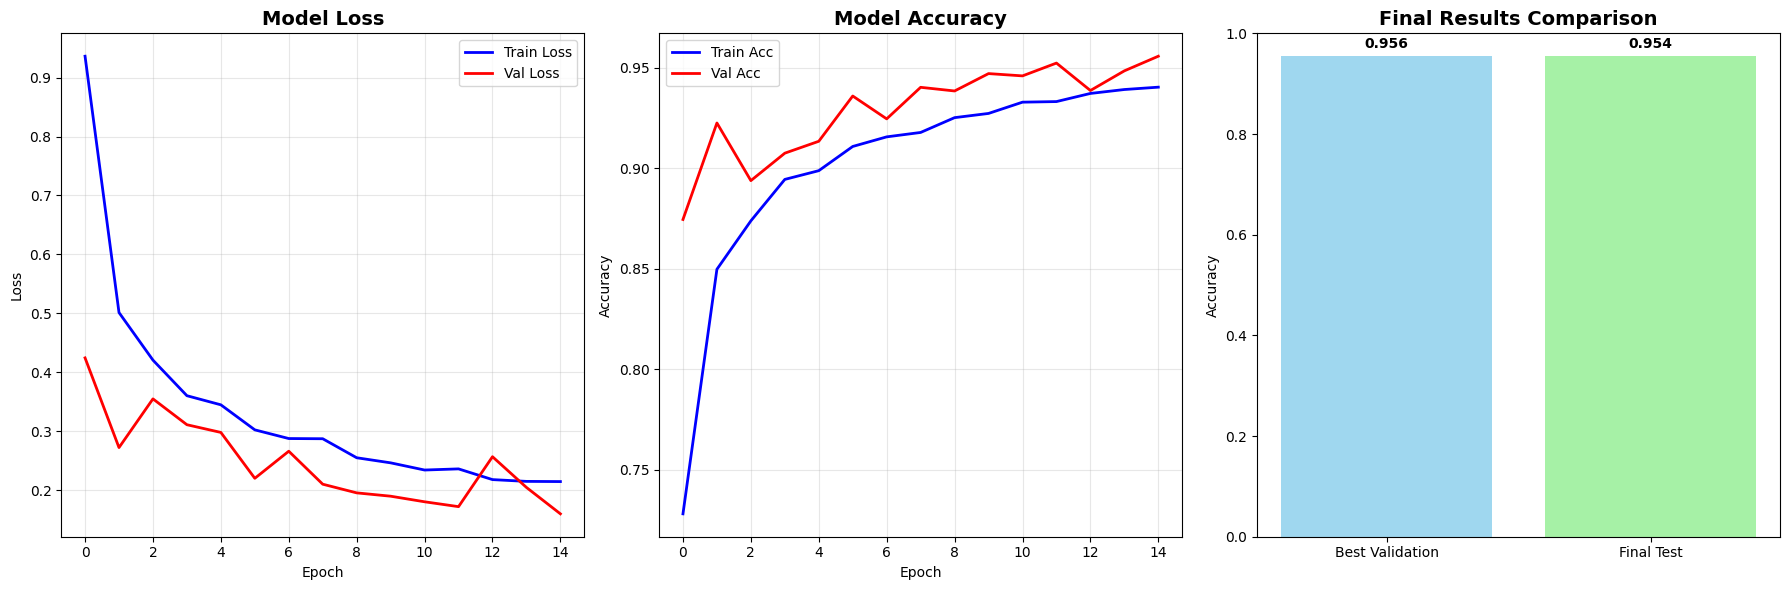


 Detailed Classification Report:
                      precision    recall  f1-score   support

      Apple__Healthy       0.99      0.98      0.98       366
       Apple__Rotten       0.99      0.95      0.97       439
     Banana__Healthy       0.99      1.00      0.99       300
      Banana__Rotten       0.99      1.00      0.99       419
 Bellpepper__Healthy       1.00      0.80      0.89        92
  Bellpepper__Rotten       0.81      0.76      0.79        89
     Carrot__Healthy       0.97      0.91      0.94        93
      Carrot__Rotten       0.89      0.87      0.88        87
   Cucumber__Healthy       0.96      1.00      0.98        91
    Cucumber__Rotten       0.89      0.96      0.92        89
      Grape__Healthy       0.88      1.00      0.94        30
       Grape__Rotten       0.96      0.90      0.93        30
      Guava__Healthy       1.00      1.00      1.00        30
       Guava__Rotten       0.83      0.97      0.89        30
     Jujube__Healthy       0.94    

In [18]:

# CELL 10: Evaluate and Visualize



print(f"\n Loading best model for final evaluation...")
model.load_state_dict(torch.load('/content/best_freshguard_model.pth'))
model.eval()


print(" Final test evaluation...")
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc="Testing"):
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())


test_accuracy = accuracy_score(all_targets, all_predictions)


print(f"\n Final Results:")
print(f"  Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"  Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


plt.figure(figsize=(18, 6))


plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss', linewidth=2, color='blue')
plt.plot(history['val_loss'], label='Val Loss', linewidth=2, color='red')
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train Acc', linewidth=2, color='blue')
plt.plot(history['val_acc'], label='Val Acc', linewidth=2, color='red')
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(1, 3, 3)
results = [best_val_acc, test_accuracy]
labels = ['Best Validation', 'Final Test']
colors = ['skyblue', 'lightgreen']

bars = plt.bar(labels, results, color=colors, alpha=0.8)
plt.title('Final Results Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)


for bar, result in zip(bars, results):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{result:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


print(f"\n Detailed Classification Report:")
report = classification_report(all_targets, all_predictions, target_names=class_names)
print(report)

In [19]:
# CELL 11: Download Trained Model



from google.colab import files

print(" Downloading trained model to your computer...")
files.download('/content/best_freshguard_model.pth')


summary = {
    'model_name': 'EfficientNet-B0',
    'num_classes': num_classes,
    'total_params': total_params,
    'best_val_accuracy': best_val_acc,
    'test_accuracy': test_accuracy,
    'training_epochs': len(history['train_loss']),
    'device_used': str(device)
}

print(f"\n FreshGuard AI Training Complete!")
print(f" Summary:")
for key, value in summary.items():
    print(f"  {key}: {value}")

print(f"\n Your model is ready to use!")
print(f" Model file downloaded: best_freshguard_model.pth")
print(f" You can now use this model in your local projects!")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 FreshGuard AI Training Complete!
 Summary:
  model_name: EfficientNet-B0
  num_classes: 28
  total_params: 4801944
  best_val_accuracy: 0.9558287795992714
  test_accuracy: 0.9540072859744991
  training_epochs: 15
  device_used: cuda

 Your model is ready to use!
 Model file downloaded: best_freshguard_model.pth
 You can now use this model in your local projects!
